# Segmentation of Medical Scans using VAE's - Part 2/3
This series of notebooks enables reproduceability of our final models and testing results.

The second notebook goes through the process of creating, training and tuning a variational autoencoder to be able to accurately represent our data in a lower-dimensional latent space.

We import some necessary libraries, and check if our GPU is available, while also retrieving some system stats. We need a lot of RAM, because our selected datasets are very large. We setup up some global constants.

In [15]:
# For ML
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.optim as optim

# For displaying and evaluating results.
import numpy as np
from matplotlib import pyplot as plt

# For monitoring resource-usage and progress.
from timeit import default_timer as timer
import psutil
from os.path import join

# Our own utility functions, constants and classes.
from utility import CT_Dataset, list_checkpoints, save_checkpoint, load_model, load_optimizer, superimpose, draw

# Our own DL models.
from models import VAEModel, Conv, ConvTranspose


# Paths.
root_dir = '../' # Relative to the working directory.
raw_data_dir = join(root_dir, 'raw_data')
prep_data_dir = join(root_dir, 'prep_data')
losses_dir = join(root_dir, 'losses')
models_dir = join(root_dir, 'saved_models')
checkpoint_dir = join(root_dir, 'checkpoints')


# Setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('CUDA version:', torch.version.cuda)

available_ram = round(psutil.virtual_memory()[0]/1000000000,2)
print('RAM: ' + str(available_ram) + 'GB')

Using cuda
NVIDIA GeForce RTX 2060 with Max-Q Design
CUDA version: 11.7
RAM: 33.74GB


We create a function, which will split a dataset and create appropriate dataloaders. The dataset is created later.

In [2]:
def make_loaders(data, batch_size):
    N = len(data); N_t = int(0.9*N); N_d = N - N_t
    train_data, dev_data = D.random_split(data, [N_t, N_d])
    train_loader = D.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    dev_loader = D.DataLoader(dev_data, batch_size=batch_size, shuffle=True)
    return train_loader, dev_loader

We define a custom loss function, which combines binary-cross-entropy loss and Kullback–Leibler divergence. We found that if the KLD loss is not scaled down, the model will cheat, i.e. not generalize, and simply output the same correct output, everytime.

We also define a training-routine for a single epoch, i.e. a full round of training data, as well as an evaluation routine.

In [3]:
def loss_fn(batch, recon, mu, log_var):
    recon_loss = nn.BCELoss(reduction='mean') 
    kld = (-0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp()))

    # Return combined reconstruction-loss and KL-divergence.
    return recon_loss(recon, batch) + 0.1 * kld
    
def train_epoch(model, optimizer, train_loader):
    model.train() # DO update model.
    losses = 0 # For logging losses.

    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, log_var = model(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        loss.backward()
        optimizer.step()
        losses += loss.item() # Append this loss.
        
    return losses / len(train_loader) # Return Average loss.

def evaluate(model, dev_loader):
    model.eval() # Do NOT update model.
    losses = 0

    for data in dev_loader: # Use development set instead.
        x = data[0].to(device)
        x_hat, mu, log_var = model.forward(x)
        loss = loss_fn(x, x_hat, mu, log_var)
        losses += loss.item()

    return losses / len(dev_loader)

We create an instance of the CT_Dataset, specifying the organ, on which we wish to train our model. In this case, the lung set. This set is passed onto the dataloaders. We experimented with different batch-sizes and found that 32 was the maximum size, our hardware could handle. 

Be careful with running this, as the dataset variable will take up a lot of space in RAM.

In [7]:
resolution = 2**8 # 2**8 = 256
batch_size = 32;
dataset = CT_Dataset(prep_data_dir, 'lung', resolution)
train_loader, dev_loader = make_loaders(dataset, batch_size)

# Checking if the output dimensions are correct.
image, label = dataset.__getitem__(1)
print(np.shape(image))
batch = next(iter(train_loader))
print(np.shape(batch[0]))

torch.Size([1, 256, 256])
torch.Size([32, 1, 256, 256])


We create an untrained instance of our `VAEModel` class, which we have defined in the `models.py` file. We specify an optimizer, as well as a learning rate scheduler. We found that the `AdamW` optimizer, which is Adam with weight-decay, works slightly better than regular `Adam`. 

We played around with the learning-rate and found 0.004 to be the maximum starting-rate, which did not cause overshooting, but converged fairly quickly.

We also found that using a learning-rate schedular with a small step-size and low weight decay factor decreased convergence-time.

In [4]:
vae_model = VAEModel(base=16).to(device)

optimizer = optim.AdamW(vae_model.parameters(), lr=4e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

Finally, we train our model. The block can - if specified - load in and record checkpoints using the utility-functions, we have defined in `utility.py` file. A checkpoint is the state of the model, as well as the state of the optimizer.

If checkpointing is enabled, the routine start from the last recorded checkpoint and continue training, until it reaches `total_epochs`.

In [6]:
total_epochs = 0 # CHANGE TO TRAIN.
use_checkpoint = False; record_checkpoint = False

train_losses = []; dev_losses = []; lrs = []

# Load last checkpoint, if present.
if use_checkpoint and len(list_checkpoints(checkpoint_dir)) != 0:
    vae_model = load_model(checkpoint_dir, vae_model)
    optimizer = load_optimizer(checkpoint_dir, optimizer)
    trained_epochs = max(list_checkpoints(checkpoint_dir))
    print('Training from epoch ' + str(trained_epochs))
else:
    print('Training from scratch:')
    trained_epochs = 0;

try:
    for epoch in range(trained_epochs+1, total_epochs+1):
        lrs.append(optimizer.param_groups[0]['lr'])
        start_time = timer()
        train_loss = train_epoch(vae_model, optimizer, train_loader)
        train_losses.append(train_loss)
        end_time = timer() # To time this epoch.
        dev_loss = evaluate(vae_model, dev_loader)
        dev_losses.append(dev_loss)
        scheduler.step()

        trained_epochs = epoch
        
        # Print current loss-metrics.
        print((f"Epoch {epoch}:, Train-loss: {train_loss:.4f}, Dev-loss: {dev_loss:.4f}, "f"Epoch-time = {(end_time - start_time):.3f}s"))

        # Record checkpoint every 5th epoch, if enabled.
        if epoch % 5 == 0 and record_checkpoint:
            save_checkpoint(checkpoint_dir, trained_epochs, vae_model, optimizer)
        
    print('Training completed.')  

# If manually interrupted, record checkpoint at last epoch.
except KeyboardInterrupt:
    print('Manually stopped.')
    save_checkpoint(checkpoint_dir, trained_epochs, vae_model, optimizer)

print('Checkpoint saved.')

Training from scratch:
Training completed.
Checkpoint saved.


We save the trained VAE model along with loss metrics. The longest, we've trained is 70 epochs, which took around an hour. This model was saved.

In [7]:
# CAREFUL NOT TO OVERWRITE.
model_num = 2; save = False

if save:
    torch.save(vae_model,
        join(models_dir, 'vae_model_' + str(model_num) + '.pt'))

    torch.save(train_losses,
        join(losses_dir, 'vae_train_losses_' + str(model_num) + '.pt'))

    torch.save(dev_losses,
        join(losses_dir, 'vae_dev_losses_'  + str(model_num) + '.pt'))

Now that we have trained and saved a model, we can load it in anywhere.

In [5]:
vae_model = torch.load(join(models_dir, 'vae_model.pt'))

We check if the VAE is able to reconstruct an approximation of the orignal image from its feature vector z. If it is able to do this, it means that the latent space accurately represents the full space of the images. 

To try different images, simply run the block below.

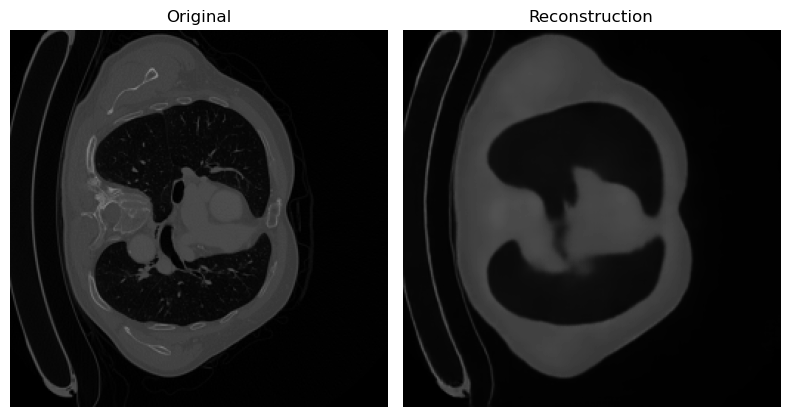

In [36]:
vae_model.eval() # Tell model to not update weights.

original = next(iter(dev_loader))[0][0].view(1, 1, 256, 256).to(device)
reconstruction = vae_model.forward(original)[0]

fig, axs = plt.subplots(1, 2, figsize=(8,5))
img_0 = original.cpu().view(256,256).detach().numpy()
img_1 = reconstruction.cpu().view(1, 256,256)[0].detach().numpy()
axs[0].imshow(img_0, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Original')
axs[1].set_title('Reconstruction')
axs[1].imshow(img_1, vmin=0, vmax=1, cmap='gray')
axs[0].set_axis_off()
axs[1].set_axis_off()
fig.canvas.draw()
plt.tight_layout()
plt.savefig('../figures/vae_reconstruction.svg')

We plot the loss metrics for the last 45 epochs of a 70-epoch-long training run. The initial training run was for 25 epochs, at which point the progress was saved and resumed later to reach 70 epochs. 

The loss-data from the first run was lost, but was also exponentially decaying. 

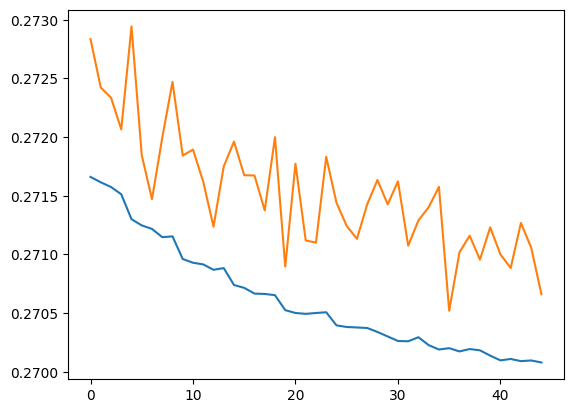

In [10]:
plt.plot(np.array(torch.load(join(losses_dir, 'vae_train_losses.pt'))))
plt.plot(np.array(torch.load(join(losses_dir, 'vae_dev_losses.pt'))))